In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt; plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


#### Scope of ML plan:
- heavily imbalanced target variable
- 97.75% of order are not fraud, so an accuracy less than 97.75% is unacceptable.
- precision will be the key assessment statistic. The model should avoid making false claims of fraud.
- A second model is needed to account for possibility that a new order has a value for "Order City" which is foreign to the model
---


#### Some useful functions:

In [ ]:
def model_results(mod, label, X_test, y_test):
    y_pred = mod.predict(X_test)
    
    pres = precision_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    results = pd.DataFrame({ label:[pres, rec, acc, roc] })
    results.index = ['Precision','Recall','Accuracy','ROC AUC']

    return results

---

In [2]:
data = pd.read_csv('/Users/willfitzhugh/Desktop/Coding/Supply-Chain-Analysis/Data/Model/FraudData_1.0.csv')
data.head(2)

,ScheduledShippingDays,OrderSales,ProductCategory,Customer City,Customer State,ProductDepartment,Order City,Order Country,Order Item Discount Rate,Order Item Profit Ratio,...,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,OrderDOW_Friday,OrderDOW_Monday,OrderDOW_Saturday,OrderDOW_Sunday,OrderDOW_Thursday,OrderDOW_Tuesday,OrderDOW_Wednesday
0,4,314.640015,5,4,4,4,5,3,0.04,0.29,...,0,0,1,0,0,0,0,0,0,1
1,4,311.359985,5,4,4,4,1,4,0.05,-0.80,...,0,0,1,0,0,1,0,0,0,0


In [3]:
#train test split
X = data.drop(columns=['IsFraud'])
y = data.IsFraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

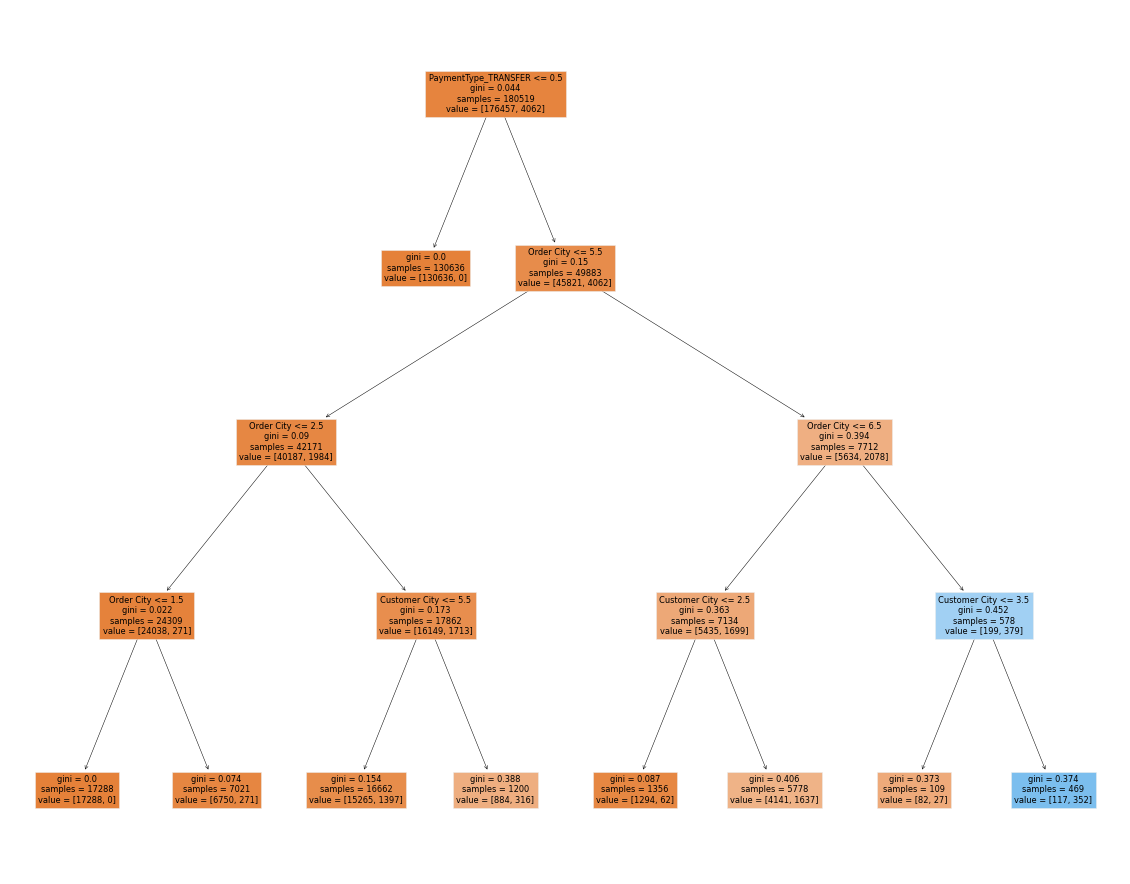

In [72]:

tree = DecisionTreeClassifier(max_depth = 4).fit( X, y )

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree, feature_names = X.columns, filled = True);

---
# Random Forest Model

In [59]:
RFC = RandomForestClassifier()

#grid search
grid_values = {
    'criterion':['gini', 'log_loss'],
    'n_estimators':[300, 400, 500, 600]
}
RFC_gridsearch = GridSearchCV(RFC, param_grid = grid_values, scoring = 'precision', cv=5)
RFC_gridsearch.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'log_loss'],
                         'n_estimators': [300, 400, 500, 600]},
             scoring='precision')

In [60]:
#grid search CV results
pd.DataFrame(RFC_gridsearch.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,26.709864,0.338703,1.112333,0.050574,log_loss,600,"{'criterion': 'log_loss', 'n_estimators': 600}",0.918182,0.864662,0.923077,0.843750,0.916667,0.893267,0.032641,1
6,22.083773,0.387894,0.965336,0.084706,log_loss,500,"{'criterion': 'log_loss', 'n_estimators': 500}",0.882883,0.877863,0.898305,0.838462,0.901639,0.879830,0.022546,2
3,27.251068,0.609748,1.121671,0.108828,gini,600,"{'criterion': 'gini', 'n_estimators': 600}",0.913793,0.877698,0.902985,0.817518,0.885496,0.879498,0.033492,3
5,17.088964,0.429103,0.688480,0.049241,log_loss,400,"{'criterion': 'log_loss', 'n_estimators': 400}",0.889831,0.856061,0.913043,0.849624,0.888889,0.879490,0.023503,4
1,17.581950,1.190574,0.778320,0.071299,gini,400,"{'criterion': 'gini', 'n_estimators': 400}",0.884298,0.866197,0.916667,0.839161,0.889764,0.879217,0.025743,5


In [39]:
RFC = RandomForestClassifier(criterion='log_loss',n_estimators=400)
RFC.fit(X_train, y_train)
print('Train Accuracy: ', RFC.score(X_train, y_train))
print('Test Accuracy: ', RFC.score(X_test, y_test))

Train Accuracy:  0.9999762588732461
Test Accuracy:  0.9817933377649752


In [40]:
y_pred = RFC.predict(X_test)
confusion_matrix(y_pred, y_test, labels=[1,0])

array([[  299,    32],
       [  954, 52871]])

In [41]:
RFC_results = model_results(mod=RFC, label='RFC', X_test = X_test, y_test=y_test)
RFC_results

,RFC
Precision,0.903323
Recall,0.238627
Accuracy,0.981793
ROC AUC,0.619011


In [ ]:
'''
this random forest model correctly predicts 311 fraud cases out of 1253 in the total test set, and only incorrectly
classifies 29 non-fraud cases as fraud. If the company were to automatically disregard these 311 orders marked as 
fraud by, they would save $X, and would only lose $X on real orders presumed to be fraud. The other 942 cases which
are not marked as fraud can be assessed by human judgement. 

This model identifies 24.7% of fraud orders, while only misidentifying 0.057% of legitamite orders as fraud.

This model correctly identifies over 10 fraud orders for every order misclassified as fraud.
'''

In [ ]:
'''
The purpose of this model is to save this company money by detecting likely fraud orders. By the same token, the
the model should not incorrectly mark orders as fraud, as canceling a non-fraud order loses the company money just
the same as accepting a fraud order. As such, the model will aim to reduce false positives.

'''

---
# Boosting Model

In [96]:
GBC = GradientBoostingClassifier()

#grid search
grid_values = {
    'learning_rate':[.1, .5],
    'n_estimators':[25, 50, 100],
    'max_depth':[1]
}
GBC_gridsearch = GridSearchCV(GBC, param_grid=grid_values, scoring=['roc_auc','precision'], refit='precision', cv=5)
GBC_gridsearch.fit(X_train, y_train.values.ravel())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Fram

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [1],
                         'n_estimators': [25, 50, 100]},
             refit='precision', scoring=['roc_auc', 'precision'])

In [ ]:
# this warning is happening because the model doesn't predict any positives in the cv case, because the cv case
#has less data and there are already so few positive cases.

In [97]:
#results
pd.DataFrame(GBC_gridsearch.cv_results_).sort_values(by='rank_test_precision').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_roc_auc,split1_test_roc_auc,...,std_test_roc_auc,rank_test_roc_auc,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision
1,2.289988,0.113438,0.043430,0.002099,0.1,1,50,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.957674,0.964329,...,0.003193,5,0.708333,0.928571,0.791667,0.750000,0.892857,0.814286,0.083791,1
2,4.507367,0.206402,0.060600,0.005625,0.1,1,100,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.962160,0.966437,...,0.002511,4,0.730159,0.826087,0.730159,0.657534,0.763636,0.741515,0.054685,2
3,1.105726,0.049284,0.035278,0.001480,0.5,1,25,"{'learning_rate': 0.5, 'max_depth': 1, 'n_esti...",0.962656,0.967013,...,0.002324,3,0.566176,0.828571,0.718750,0.628205,0.754386,0.699218,0.092628,3
4,2.146888,0.098434,0.045017,0.007864,0.5,1,50,"{'learning_rate': 0.5, 'max_depth': 1, 'n_esti...",0.963720,0.966837,...,0.001975,2,0.594595,0.800000,0.723077,0.609195,0.745763,0.694526,0.079791,4
5,4.102260,0.116610,0.060698,0.003546,0.5,1,100,"{'learning_rate': 0.5, 'max_depth': 1, 'n_esti...",0.963611,0.966742,...,0.001946,1,0.638298,0.756098,0.691358,0.548077,0.765625,0.679891,0.080491,5


In [36]:
GBC = GradientBoostingClassifier(learning_rate=.1, n_estimators=50,max_depth=1)
GBC.fit(X_train, y_train)
y_pred = GBC.predict(X_test)
confusion_matrix(y_pred, y_test, labels=[1,0])

array([[   43,     5],
       [ 1210, 52898]])

In [37]:
print('Train Accuracy: ', GBC.score(X_train, y_train))
print('Test Accuracy: ', GBC.score(X_test, y_test))

Train Accuracy:  0.9783797472361372
Test Accuracy:  0.9775648127631288


In [38]:
GBC_results = model_results(mod=GBC, label='GBC', X_test = X_test, y_test=y_test)
GBC_results

,GBC
Precision,0.895833
Recall,0.034318
Accuracy,0.977565
ROC AUC,0.517112


---

# Logistic Regression Model
tldr; not the right model for this problem

In [7]:
# scale data
sc = StandardScaler()
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

sc.fit(X) #fit over full dataset

X_train_sc.loc[:,:] = sc.transform(X_train_sc)
X_test_sc.loc[:,:] = sc.transform(X_test_sc)

In [91]:
#grid search
LR = LogisticRegression(max_iter = 4000)

grid_values = {
    'penalty':['l1', 'l2'],
    'solver':['liblinear', 'saga'],
    'tol':[1, .1, .01]
}
LR_gridsearch = GridSearchCV(LR, param_grid=grid_values, scoring=['roc_auc','precision'], refit='precision', cv=5)
LR_gridsearch.fit(X_train_sc, y_train.values.ravel())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Fram

KeyboardInterrupt: 

In [54]:
#results
pd.DataFrame(LR_gridsearch.cv_results_).sort_values(by='rank_test_precision').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_solver,param_tol,params,split0_test_roc_auc,split1_test_roc_auc,...,std_test_roc_auc,rank_test_roc_auc,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision
6,0.260152,0.006790,0.020987,0.000386,l2,liblinear,1,"{'penalty': 'l2', 'solver': 'liblinear', 'tol'...",0.960363,0.964868,...,0.002507,12,0.727273,0.916667,0.785714,0.866667,0.933333,0.845931,0.078458,1
0,0.327985,0.044267,0.026328,0.003069,l1,liblinear,1,"{'penalty': 'l1', 'solver': 'liblinear', 'tol'...",0.960265,0.965011,...,0.002485,11,0.750000,0.742857,0.560976,0.750000,1.000000,0.760767,0.139787,2
3,0.093244,0.003286,0.013189,0.000107,l1,saga,1,"{'penalty': 'l1', 'solver': 'saga', 'tol': 1}",0.961509,0.964647,...,0.002105,9,0.506667,0.663366,0.530435,0.476190,0.613445,0.558021,0.069662,3
9,0.082599,0.001114,0.013552,0.001248,l2,saga,1,"{'penalty': 'l2', 'solver': 'saga', 'tol': 1}",0.961639,0.964238,...,0.002055,10,0.480000,0.623853,0.537037,0.516854,0.608696,0.553288,0.054794,4
1,0.658260,0.053701,0.026004,0.001986,l1,liblinear,0.1,"{'penalty': 'l1', 'solver': 'liblinear', 'tol'...",0.962015,0.965219,...,0.002197,5,0.487500,0.594937,0.525641,0.488372,0.653465,0.549983,0.064841,5


In [50]:
LR = LogisticRegression(penalty='l2', tol=1, solver='liblinear')
LR.fit(X_train_sc, y_train)

y_pred = LR.predict(X_test_sc)
precision_score(y_test, y_pred)

LogisticRegression(solver='liblinear', tol=1)

In [55]:
confusion_matrix(y_pred, y_test, labels=[1,0])

array([[   21,     1],
       [ 1232, 52902]])

In [56]:
#grid search 2.0
LR = LogisticRegression(max_iter = 4000)

grid_values = {
    'penalty':['l1', 'l2'],
    'solver':['liblinear'],
    'tol':[1.5, 1.25, 1, .75, .5]
}
LR_gridsearch = GridSearchCV(LR, param_grid=grid_values, scoring=['roc_auc','precision'], refit='precision', cv=5)
LR_gridsearch.fit(X_train_sc, y_train.values.ravel())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Fram

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=4000),
             param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'],
                         'tol': [1.5, 1.25, 1, 0.75, 0.5]},
             refit='precision', scoring=['roc_auc', 'precision'])

In [57]:
#results 2.0
pd.DataFrame(LR_gridsearch.cv_results_).sort_values(by='rank_test_precision').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_solver,param_tol,params,split0_test_roc_auc,split1_test_roc_auc,...,std_test_roc_auc,rank_test_roc_auc,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision
0,0.304916,0.024493,0.027573,0.003180,l1,liblinear,1.5,"{'penalty': 'l1', 'solver': 'liblinear', 'tol'...",0.960565,0.964174,...,0.002396,9,1.000000,1.000000,0.553191,1.000000,0.857143,0.882067,0.173496,1
6,0.292013,0.018991,0.022813,0.001613,l2,liblinear,1.25,"{'penalty': 'l2', 'solver': 'liblinear', 'tol'...",0.960363,0.964868,...,0.002507,6,0.727273,0.916667,0.785714,0.866667,0.933333,0.845931,0.078458,2
7,0.278874,0.008662,0.021992,0.000379,l2,liblinear,1,"{'penalty': 'l2', 'solver': 'liblinear', 'tol'...",0.960363,0.964868,...,0.002507,6,0.727273,0.916667,0.785714,0.866667,0.933333,0.845931,0.078458,2
8,0.271599,0.011368,0.020872,0.000690,l2,liblinear,0.75,"{'penalty': 'l2', 'solver': 'liblinear', 'tol'...",0.960363,0.964868,...,0.002507,6,0.727273,0.916667,0.785714,0.866667,0.933333,0.845931,0.078458,2
1,0.339064,0.041515,0.027144,0.002062,l1,liblinear,1.25,"{'penalty': 'l1', 'solver': 'liblinear', 'tol'...",0.959718,0.964822,...,0.002210,5,0.700000,0.933333,0.769231,0.789474,0.916667,0.821741,0.089536,5


In [58]:
LR = LogisticRegression(penalty='l1', tol=1.5, solver='liblinear')
LR.fit(X_train_sc, y_train)

y_pred = LR.predict(X_test_sc)
precision_score(y_test, y_pred)

0.7543859649122807

In [59]:
confusion_matrix(y_pred, y_test, labels=[1,0])

array([[   43,    14],
       [ 1210, 52889]])

In [ ]:
#for whatever reason (I could probably find out in what ways it is worse) grid search 2.0 suggested a slightly
#worse model.

In [56]:
LR = LogisticRegression(penalty='l2', tol=1, solver='liblinear')
LR.fit(X_train_sc, y_train)

y_pred = LR.predict(X_test_sc)

LR_results = model_results(mod = LR, label = 'LR', X_test = X_test_sc, y_test = y_test)
LR_results

,LR
Precision,0.954545
Recall,0.016760
Accuracy,0.977232
ROC AUC,0.508370


---
# KNN Model

In [112]:
# K Nearest Neighbors
KNN = KNeighborsClassifier()

#grid search
grid_values = {
    'n_neighbors':[1, 3, 5, 7, 10, 15, 20]
}
KNN_gridsearch = GridSearchCV(KNN, param_grid = grid_values, scoring = ['precision','roc_auc'], refit=False, cv=5)
KNN_gridsearch.fit(X_train_sc, y_train.values.ravel())

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 10, 15, 20]}, refit=False,
             scoring=['precision', 'roc_auc'])

In [113]:
pd.DataFrame(KNN_gridsearch.cv_results_).sort_values(by='rank_test_precision').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,std_test_precision,rank_test_precision,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
5,0.034344,0.004943,6.114386,0.180119,15,{'n_neighbors': 15},0.722222,0.763158,0.739130,0.928571,...,0.086130,1,0.903576,0.917698,0.896143,0.897083,0.900850,0.903070,0.007785,2
6,0.032637,0.001660,6.109574,0.100629,20,{'n_neighbors': 20},0.666667,0.750000,0.750000,0.928571,...,0.100283,2,0.911654,0.926131,0.911105,0.908221,0.915282,0.914479,0.006244,1
4,0.032041,0.003043,6.250215,0.464877,10,{'n_neighbors': 10},0.666667,0.735849,0.823529,0.804878,...,0.069221,3,0.885656,0.896579,0.870949,0.883208,0.890329,0.885344,0.008520,3
3,0.030277,0.001069,5.822027,0.120304,7,{'n_neighbors': 7},0.603053,0.631148,0.600000,0.592920,...,0.027765,4,0.867905,0.877351,0.850933,0.861245,0.876615,0.866810,0.009915,4
2,0.029173,0.001037,5.735793,0.074879,5,{'n_neighbors': 5},0.577320,0.554974,0.551546,0.567416,...,0.020802,5,0.848595,0.855134,0.826959,0.840222,0.850410,0.844264,0.009905,5


In [33]:
KNN = KNeighborsClassifier(n_neighbors=15)
KNN.fit(X_train_sc, y_train)

y_pred = KNN.predict(X_test_sc)
confusion_matrix(y_pred, y_test, labels=[1,0])

array([[   75,    42],
       [ 1178, 52861]])

In [34]:
print('Train Accuracy: ', KNN.score(X_train_sc, y_train))
print('Test Accuracy: ', KNN.score(X_test_sc, y_test))

Train Accuracy:  0.9794243568133076
Test Accuracy:  0.977472486889726


In [44]:
KNN_results = model_results(mod=KNN, label='KNN', X_test = X_test_sc, y_test=y_test)
KNN_results

,KNN
Precision,0.641026
Recall,0.059856
Accuracy,0.977472
ROC AUC,0.529531


---
# SVMC Model

In [ ]:
SVMC = SVC()

#grid search
grid_values = {
    'C':[1.0],
    'kernel':['linear','rbf']
}
SVMC_gridsearch = GridSearchCV(SVMC, param_grid = grid_values, scoring = ['precision','roc_auc'], refit=False, cv=5)
SVMC_gridsearch.fit(X_train_sc, y_train.values.ravel())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.DataFrame(SVMC_gridsearch.cv_results_).sort_values(by='rank_test_precision').head()

In [8]:
SVMC = SVC()
SVMC.fit(X_train_sc, y_train)

y_pred = SVMC.predict(X_test_sc)

confusion_matrix(y_pred, y_test, labels=[1,0])

array([[   13,     0],
       [ 1240, 52903]])

In [9]:
print('Train Accuracy: ', SVMC.score(X_train_sc, y_train))
print('Test Accuracy: ', SVMC.score(X_test_sc, y_test))

Train Accuracy:  0.9783639198183013
Test Accuracy:  0.9771031833961149


In [45]:
SVMC_results = model_results(mod=SVMC, label='SVMC', X_test = X_test_sc, y_test=y_test)
SVMC_results

,SVMC
Precision,1.000000
Recall,0.010375
Accuracy,0.977103
ROC AUC,0.505188


---
# Summarize Results:


In [58]:
final_results = pd.concat([RFC_results, GBC_results, KNN_results, SVMC_results, LR_results], axis = 1)
final_results

,RFC,GBC,KNN,SVMC,LR
Precision,0.903323,0.895833,0.641026,1.000000,0.954545
Recall,0.238627,0.034318,0.059856,0.010375,0.016760
Accuracy,0.981793,0.977565,0.977472,0.977103,0.977232
ROC AUC,0.619011,0.517112,0.529531,0.505188,0.508370


In [61]:
# random forest model is pretty good
#should try an ensemble